# GLAD Alert widgets

In [9]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [10]:
from datetime import date

In [11]:
from datetime import timedelta

In [12]:
import math

ADM0 REQUEST:

https://production-api.globalforestwatch.org/v1/glad-alerts/admin/COD?period=2017-01-20%2C2017-12-26&thresh=30&_=1516027383380
    
ADM1 REQUEST:

https://production-api.globalforestwatch.org/v1/glad-alerts/admin/COD/4?period=2017-01-20%2C2017-12-26&thresh=30&_=1516027383381
    
CUSTOM SHAPE REQUEST:  
https://production-api.globalforestwatch.org/v1/glad-alerts?geostore=40c6e39d84c6fb3c5e3781cc69fe7444&period=2017-10-01%2C2017-12-26&thresh=30&_=1516027383379


### REQUEST

base url: ```https://production-api.globalforestwatch.org/v1/glad-alerts/admin```

iso: ```/{ISO}``` (iso3)

adm1: ```/{adm1}``` (numerical)

query: ```?```

dates: ```period={start},{end}``` (YYYY-MM-DD)

thresh: ```thresh={threshold}```


### RESPONSE

```JSON
{
    "data": {
        "attributes": {
        "areaHa": 234363285.93553916,
        "downloadUrls": {
            "csv": "...",
            "json": "..."
            },
        "value": 2126428
        },

    "id": "db34c2d9-77b8-43ee-b101-f499e39d1597",
    "period": "2017-01-20,2017-12-26",
    "type": "glad-alerts"
        }
}
```

So we have the following variables:

- data.areaHa (area in ha)
- data.value (no of alerts in the period)
- period (start- and end- dates)

In [13]:
ds = 'db34c2d9-77b8-43ee-b101-f499e39d1597'

In [14]:
iso = 'BRA'
adm1 = None
adm2 = None
start_date = '2017-01-20'
end_date = '2017-12-26'
threshold = 30

In [15]:
# Example of adm0 request
url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}"
properties = {"period" : start_date + ',' + end_date,
              "thresh" : threshold}
r = requests.get(url, params = properties)

print(r.url)
print(f'Status: {r.status_code}')

data = r.json()

pprint(data)

https://production-api.globalforestwatch.org/v1/glad-alerts/admin/BRA?period=2017-01-20%2C2017-12-26&thresh=30
Status: 200
{'data': {'attributes': {'areaHa': 855189203.6641197,
                         'downloadUrls': {'csv': '/download/db34c2d9-77b8-43ee-b101-f499e39d1597?sql=SELECT '
                                                 'lat, long, confidence_text, '
                                                 'country_iso, state_id, '
                                                 'dist_id, year, julian_day '
                                                 'FROM '
                                                 'index_db34c2d977b843eeb101f499e39d1597 '
                                                 'WHERE ((year = 2017 and '
                                                 'julian_day >= 20 and '
                                                 'julian_day <= 360)) AND '
                                                 "(country_iso = 'BRA')ORDER "
                            

In [16]:
# Example of adm1 request
url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}/{adm1}"
properties = {"period" : start_date + ',' + end_date,
              "thresh" : threshold}
r = requests.get(url, params = properties)

print(r.url)
print(f'Status: {r.status_code}')

data = r.json()

pprint(data)

https://production-api.globalforestwatch.org/v1/glad-alerts/admin/BRA/None?period=2017-01-20%2C2017-12-26&thresh=30
Status: 400
{'errors': [{'detail': 'For state and district queries please use numbers',
             'status': 400}]}


In [17]:
def get_glads(start_date, end_date, iso, adm1=None, threshold=30):
   
    if adm1:
#         print('Request for adm1 area')
        url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}/{adm1}" 
    else:
#         print('Request for adm0 area')
        url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}" 
        
    properties = {"period" : start_date + ',' + end_date, "thresh" : threshold}
    r = requests.get(url, params = properties)
    
    data = r.json().get('data')
#     pprint(data)
    
    return {
            'areaHa': data.get('attributes').get('areaHa'),
            'count': data.get('attributes').get('value')
    }

In [18]:
iso = 'BRA'
adm1 = None
start_date = '2017-01-20'
end_date = '2017-12-26'
threshold = 30

In [19]:
data = get_glads(start_date=start_date, end_date=end_date, iso=iso, adm1=adm1, threshold=threshold)

In [20]:
data

{'areaHa': 855189203.6641197, 'count': 16903694}

In [21]:
# No of days elapsed using the 'datetime' library

f_date = date(int(start_date[:4]),int(start_date[5:7]), int(start_date[8:10]))
l_date = date(int(end_date[:4]),int(end_date[5:7]), int(end_date[8:10]))
delta = l_date - f_date

days = delta.days
print(days)

340


### Dynamic Sentence

In [22]:
### Between X and Y there have been Z GLADS alerts in ISO/adm1, around (Y-X)/Z per day.

# Variation Statistics

- Number/Area compared to previous year(s)
- In the last week/month/year from today
    
  

In [23]:
# What is the temporal density of alerts in this period?

alerts_per_day = data.get('count')/days
print(alerts_per_day)

49716.74705882353


In [24]:
new_start_date = str(int(start_date[0:4])-1) + '-' + start_date[5:]
new_start_date

'2016-01-20'

In [25]:
new_end_date = str(int(end_date[0:4])-1) + '-' + end_date[5:]
new_end_date

'2016-12-26'

In [26]:
prev_year = get_glads(start_date=new_start_date, end_date=new_end_date, iso=iso, adm1=adm1, threshold=threshold)

In [27]:
prev_year

{'areaHa': 855189203.6641197, 'count': 15324384}

In [28]:
# What is the temporal density of alerts in this period?

prev_year.get('count')/days - alerts_per_day

-4645.029411764706

In [33]:
from datetime import datetime

# Test

We need to precalc weekly stats over the entirety of the temporal data.

In [29]:
test_i = '2015-01-01'

In [35]:
date_1 = datetime.strptime(test_i, "%Y-%m-%d")
date_1

datetime.datetime(2015, 1, 1, 0, 0)

In [36]:
date_2 = date_1 + timedelta(days=7) 
date_2

datetime.datetime(2015, 1, 8, 0, 0)

In [37]:
test_f = datetime.isoformat(date_2)[:10]
test_f

'2015-01-08'

In [38]:
test_data = get_glads(start_date=test_i, end_date=test_f, iso=iso, adm1=adm1, threshold=threshold)

In [39]:
test_data

{'areaHa': 855189203.6641197, 'count': 111839}

# Weekly Stats Script

We need to precalc weekly stats over the entirety of the temporal data.

In [40]:
iso = 'BRA'
adm1 = None
week = 145
threshold = 0

In [41]:
def historic_glads_weekly(iso, adm1=None, threshold=30, start='2015-01-01', end=str(date.today())):
    if adm1:
        print(f"Collecting historical GLADS data for {adm1}, {iso} at {threshold}% tree canopy.")
    else:
        print(f"Collecting historical GLADS data for all of {iso} at {threshold}% tree canopy.")
    weekly = []
    test_i = start
    test_f = start
    week = 0
    
    while test_f < str(date.today()):
        
        print(f"{week}) starting {test_i}")
        _tmp_date = datetime.strptime(test_i, "%Y-%m-%d") + timedelta(days=7)
        test_f = datetime.isoformat(_tmp_date)[:10]
        
        data = get_glads(start_date=test_i, end_date=test_f, iso=iso, adm1=adm1, threshold=threshold)
        
        weekly.append(
            
            {
                'week': week,
                'start_date': test_i,
                'end_date': test_f,
                'count': data.get('count')
            }
        )
        
        week += 1
        test_i = test_f
        
    return weekly
        

In [42]:
%%time
historic_data = historic_glads_weekly(iso, adm1, threshold)

0) starting 2015-01-01
1) starting 2015-01-08
2) starting 2015-01-15
3) starting 2015-01-22
4) starting 2015-01-29
5) starting 2015-02-05
6) starting 2015-02-12
7) starting 2015-02-19
8) starting 2015-02-26
9) starting 2015-03-05
10) starting 2015-03-12
11) starting 2015-03-19
12) starting 2015-03-26
13) starting 2015-04-02
14) starting 2015-04-09
15) starting 2015-04-16
16) starting 2015-04-23
17) starting 2015-04-30
18) starting 2015-05-07
19) starting 2015-05-14
20) starting 2015-05-21
21) starting 2015-05-28
22) starting 2015-06-04
23) starting 2015-06-11
24) starting 2015-06-18
25) starting 2015-06-25
26) starting 2015-07-02
27) starting 2015-07-09
28) starting 2015-07-16
29) starting 2015-07-23
30) starting 2015-07-30
31) starting 2015-08-06
32) starting 2015-08-13
33) starting 2015-08-20
34) starting 2015-08-27
35) starting 2015-09-03
36) starting 2015-09-10
37) starting 2015-09-17
38) starting 2015-09-24
39) starting 2015-10-01
40) starting 2015-10-08
41) starting 2015-10-15
42

KeyboardInterrupt: 

In [43]:
pprint(historic_data[-6:-3])

NameError: name 'historic_data' is not defined

In [ ]:
max_week = len(historic_data)-1
max_week

### Dynamic Sentences

In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")

if historic_data[week].get('count') > historic_data[week-52].get('count') and historic_data[week-52].get('count'):
    print(f"an increase of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
else:
    print(f"an decrease of {historic_data[week].get('count') - historic_data[week-52].get('count')} ", end="")
    
print(f"over the corresponding week in {historic_data[week-52].get('start_date')[0:4]}. ", end="")
    
    

In [ ]:
print(f"There were {historic_data[w].get('count')} GLADS alerts reported ", end="")
print(f"in the week starting {historic_data[week].get('start_date')}, ", end="")
print(f"compared to ", end="")
n = 1

while week-(52*n) > 0:
    if n > 1:
        print(f", ", end="")
    if historic_data[week-(52*n)].get('start_date')[0:4] == '2015':
        print(f"and ", end="")
        
    if historic_data[week-(52*n)].get('count') > historic_data[week-(52*(n-1))].get('count'):
        arrow = '↑'
    elif historic_data[week-(52*n)].get('count') < historic_data[week-(52*(n-1))].get('count'):
        arrow = '↓'
    else:
        arrow = '-'
        
    print(f"{historic_data[week-(52*n)].get('count')}({arrow}) ", end="")
    print(f"in {historic_data[week-(52*n)].get('start_date')[0:4]}", end="")
    n += 1
    
print(f".", end="")
    
### Note: (↑) indicates that current year is an increse over that year, (↓) means a decrease 

# Sigma Stats
Need to calculate means and sigmas for target week (and +/- 2 weeks either side) in order to talk about whether a situation is statistically unusual/outlying.

In [ ]:
max_week = len(historic_data)-1
max_week

In [ ]:
historic_stats = []

In [ ]:
n = 0
alert_sum = 0

while week-(52*n) > 0:
    alert_sum += historic_data[week-(52*n)].get('count')
    n +=1
    
alert_mean = alert_sum/n
print(alert_mean)

In [ ]:
n = 0
alert_sqsum = 0

while week-(52*n) > 0:
    alert_sqsum += math.pow((historic_data[week-(52*n)].get('count') - alert_mean),2)
    n +=1
    
alert_sigma = math.sqrt(alert_sqsum/n)
print(alert_sigma)

In [ ]:
def historical_stats(week, historic_data):
    
    value = historic_data[week].get('count')
    ### Calc mean
    n = 0
    alert_sum = 0
        
    while week-(52*n) > 0:
        alert_sum += historic_data[week-(52*n)].get('count')
        n +=1
    alert_mean = alert_sum/(n+1)
    
    ###Now calc sigma
    n = 0
    alert_sqsum = 0

    while week-(52*n) > 0:
        alert_sqsum += math.pow((historic_data[week-(52*n)].get('count') - alert_mean),2)
        n +=1
    alert_sigma = math.sqrt(alert_sqsum/(n+1))

    return {'week': week, 'mean': alert_mean, 'sigma': alert_sigma, 'counts': value}


In [ ]:
historic_stats_array = []
week = 145

for w in range(week-2, week+3):
    _tmp_obj = historical_stats(w, historic_data)
    historic_stats_array.append(_tmp_obj)
    
historic_stats_array

In [ ]:
dataset = []
derr = []
upper = []
lower = []
upper2sig = []
lower2sig = []

for i in historic_stats_array:
    dataset.append(i.get('mean'))
    derr.append(i.get('sigma'))
    upper.append(i.get('mean')+i.get('sigma'))
    lower.append(i.get('mean')-i.get('sigma'))
    upper2sig.append(i.get('mean')+ 2*(i.get('sigma')))
    lower2sig.append(i.get('mean')- 2*(i.get('sigma')))

In [ ]:
def glads_plot(ax, dataset, derr, col_key):
    """
    Set the plot and properties of the figure sub-pannels.
    """
    lthick=1.0
    ax.plot(mrange, dataset, 'k--',lw=lthick)  # prev

    ax.fill_between(mrange, lower, upper,
                    color=col_key, linewidth=0.1,alpha=0.15)
    ax.fill_between(mrange, lower2sig, upper2sig,
                    color=col_key, linewidth=0.1,alpha=0.05)

    ax.set_xticklabels(xlabs)
    ax.set_xlim(0,5)
    return

mrange = range(0,5)
xlabs =['w-2','w-1','w0','w+1','w+2']

figBA15 = plt.figure()
figBA15.set_size_inches(20,6)
ax1 = figBA15.add_subplot(121)          

glads_plot(ax=ax1, dataset=dataset, derr=derr, col_key='r')

ax1.set_ylabel(r"Alerts", fontsize=11)
ax1.set_title('GLADS Alerts')

plt.show(figBA15)


In [ ]:
i = historic_data[week-2].get('start_date')
i

In [ ]:
f = historic_data[week+3].get('start_date')
f

In [ ]:
def historic_glads_daily(start, end, iso, adm1=None, threshold=30):
    if adm1:
        print(f"Collecting daily GLADS data for {adm1}, {iso} at {threshold}% tree canopy.")
    else:
        print(f"Collecting daily GLADS data for all of {iso} at {threshold}% tree canopy.")
    daily = []
    test_i = start
    test_f = start
    day = 0
    
    while test_f < end:
        
        print(f"{day}) starting {test_i}")
        _tmp_date = datetime.strptime(test_i, "%Y-%m-%d") + timedelta(days=1)
        test_f = datetime.isoformat(_tmp_date)[:10]
        
        data = get_glads(start_date=test_i, end_date=test_f, iso=iso, adm1=adm1, threshold=threshold)
        
        daily.append(
            
            {
                'day': day,
                'start_date': test_i,
                'end_date': test_f,
                'count': data.get('count')
            }
        )
        
        day += 1
        test_i = test_f
        
    return daily
        

In [ ]:
daily_glads = historic_glads_daily(start=i, end=f, iso=iso, adm1=adm1, threshold=threshold)

In [ ]:
pprint(daily_glads[0:3])

In [ ]:
dataset2 = []
derr2 = []
upper2 = []
lower2 = []
upper2_2sig = []
lower2_2sig = []
daily = []


for i in range(0,len(daily_glads)-1):
    daily.append(daily_glads[i].get('count'))    
    if i%7 == 0:
        n = int(i/7)
    dataset2.append(dataset[n])
    derr2.append(derr[n])
    upper2.append(upper[n])
    lower2.append(lower[n])
    upper2_2sig.append(upper2sig[n])
    lower2_2sig.append(lower2sig[n])


In [ ]:
def glads_plot2(ax, dataset, derr, col_key):
    """
    Set the plot and properties of the figure sub-pannels.
    """
    lthick=1.0
    ax.plot(mrange, dataset2, 'k--',lw=lthick)  # mean
    ax.plot(mrange, daily, 'k-',lw=lthick)  # mean

    ax.fill_between(mrange, lower2, upper2,
                    color=col_key, linewidth=0.1,alpha=0.15)
    ax.fill_between(mrange, lower2_2sig, upper2_2sig,
                    color=col_key, linewidth=0.1,alpha=0.05)


    ax.set_xlim(0,34)
    return

mrange = range(0,34)

figBA15 = plt.figure()
figBA15.set_size_inches(20,6)
ax1 = figBA15.add_subplot(121)          

glads_plot2(ax=ax1, dataset=dataset2, derr=derr2, col_key='r')

ax1.set_ylabel(r"Alerts", fontsize=11)
ax1.set_title('GLADS Alerts')

plt.show(figBA15)


### TESTING

Take a single week of data and compare that week for each year (2015-2017)

In [ ]:
iso = 'BRA'
adm1 = None
week = 145
threshold = 0

In [ ]:
i = historic_data[week-1].get('start_date')
f = historic_data[week+0].get('start_date')
daily_glads2017 = historic_glads_daily(start=i, end=f, iso=iso, adm1=adm1, threshold=threshold)

In [ ]:
i = '2016-10-05'
f = '2016-10-12'
daily_glads2016 = historic_glads_daily(start=i, end=f, iso=iso, adm1=adm1, threshold=threshold)

In [ ]:
i = '2015-10-05'
f = '2015-10-12'
daily_glads2015 = historic_glads_daily(start=i, end=f, iso=iso, adm1=adm1, threshold=threshold)

In [ ]:
glads2015 = []
glads2016 = []
glads2017 = []
glads_mean = []

for i in range(0, len(daily_glads2015)):
    glads2015.append(daily_glads2015[i].get('count'))
    glads2016.append(daily_glads2016[i].get('count'))
    glads2017.append(daily_glads2017[i].get('count'))
    glads_mean.append((glads2015[i]+glads2016[i]+glads2017[i])/3)


glads2015 = np.array(glads2015)
glads2016 = np.array(glads2016)
glads2015 = np.array(glads2015)
glads2017 = np.array(glads2017)

In [ ]:
lthick=1.0

plt.plot(glads2015, 'r--',lw=lthick)  # 2015=RED
plt.plot(glads2016, 'b--',lw=lthick)  # 2016=BLUE
plt.plot(glads2017, 'g--',lw=lthick)  # 2017=GREEN
plt.plot(glads_mean, 'k-',lw=lthick)  # mean=BLACK
plt.plot(glads_mean + std, 'k--')
plt.plot(glads_mean - std, 'k--')
plt.plot(glads_mean + std*2, 'k--')
plt.plot(glads_mean - std*2, 'k--')

plt.show()


In [ ]:
std = np.std([glads2015, glads2016, glads2017])

In [ ]:
mean = np.mean([glads2015, glads2016, glads2017])

# Testing Better Functions

```historic_data``` for 'BRA'

Use np!

In [ ]:
historic_data[0:3]

In [ ]:
def get_glads(start_date, end_date, iso, adm1=None, threshold=30):
   
    if adm1:
#         print('Request for adm1 area')
        url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}/{adm1}" 
    else:
#         print('Request for adm0 area')
        url = f"https://production-api.globalforestwatch.org/v1/glad-alerts/admin/{iso}" 
        
    properties = {"period" : start_date + ',' + end_date, "thresh" : threshold}
    r = requests.get(url, params = properties)
    
    data = r.json().get('data')
#     pprint(data)
    
    return {
            'areaHa': data.get('attributes').get('areaHa'),
            'count': data.get('attributes').get('value')
           }

In [ ]:
def historic_glads(start, end, iso, adm1=None, threshold=30, t_res='d'):
    """Takes a start-date and end-date iso-format string, returning a the GLADS reports 
    with a defined time resolution in a Area of Interest (country, adm1)"""
    
    if t_res == '6m':
        res = '6-monthly'
        dt = timedelta(weeks=26)
    elif t_res == '3m':
        res = '3-monthly'
        dt = timedelta(weeks=13)
    elif t_res == 'w':
        res = 'weekly'
        dt = timedelta(days=7)
    elif t_res == 'd':
        res = 'daily'
        dt = timedelta(days=1)
    
    if adm1:
        print(f"Collecting {res} GLADS data for {adm1}, {iso} at {threshold}% tree canopy.")
    else:
        print(f"Collecting {res} GLADS data for all of {iso} at {threshold}% tree canopy.")
        
    
    alerts_data = []
    t = 0
    
    while start > '2015-01-01':
               
        i = start
        f = start
        tmp = []
    
        while f <= end:

            _tmp_date = datetime.strptime(i, "%Y-%m-%d") + dt
            f = datetime.isoformat(_tmp_date)[:10]

            data = get_glads(start_date=i, end_date=f, iso=iso, adm1=adm1, threshold=threshold)
            
            tmp.append(

                {
                    'start_date': i,
                    'count': data.get('count')
                }
            )

            t += 1
            i = f
          
        alerts_data.append(tmp)
        _tmp_end = datetime.strptime(end, "%Y-%m-%d") - timedelta(days=365)
        end = datetime.isoformat(_tmp_end)[:10]
        _tmp_start = datetime.strptime(start, "%Y-%m-%d") - timedelta(days=365)
        start = datetime.isoformat(_tmp_start)[:10]
        
        
    return alerts_data
        

In [ ]:
glads_data = historic_glads(start='2017-12-01', end='2017-12-08', iso='BRA', adm1=None, threshold=0, t_res='d')

In [ ]:
glads_data[2]

In [ ]:
def glads_stats(data):
    
    mean = []
    std_plus1 = []
    std_minus1 = []
    std_plus2 = []
    std_minus2 = []
    count = []
    
    for j in range(0,len(data[0])):
        tmp_c = []
        for i in range(0,len(data)):
            
            if i==0:
                count.append(data[i][j].get('count'))
#             print(data[i][j].get('start_date'))
            tmp_c.append(data[i][j].get('count'))

        tmp_m = np.mean(tmp_c)
        tmp_s = np.std(tmp_c)
        
        mean.append(tmp_m)
        std_plus1.append(tmp_m+tmp_s)
        std_plus2.append(tmp_m+2*tmp_s)
        std_minus1.append(tmp_m-tmp_s)
        std_minus2.append(tmp_m-2*tmp_s)

    return {'mean': mean,
            '+1sigma': std_plus1,
            '+2sigma': std_plus2,
            '-1sigma': std_minus1,
            '-2sigma': std_minus2,
            'count': count}


In [ ]:
stats = glads_stats(glads_data)

In [ ]:
def glads_plot(stats):
    
    lthick=1.0

    plt.plot(stats.get('count'), 'r-')  # 2015=RED
    plt.plot(stats.get('mean'), 'k-',lw=lthick)  # mean=BLACK
    plt.plot(stats.get('-1sigma'), 'k--',lw=lthick)  # mean=BLACK
    plt.plot(stats.get('+1sigma'), 'k--',lw=lthick)  # mean=BLACK
    plt.plot(stats.get('-2sigma'), 'k--',lw=lthick)  # mean=BLACK
    plt.plot(stats.get('+2sigma'), 'k--',lw=lthick)  # mean=BLACK

    return plt.show()



In [ ]:
glads_plot(stats)

In [ ]:
glads_data = historic_glads(start='2017-07-01', end='2017-07-08', iso='BRA', adm1=None, threshold=0, t_res='d')

In [ ]:
stats = glads_stats(glads_data)

In [ ]:
glads_plot(stats)

In [ ]:
glads_data = historic_glads(start='2017-02-01', end='2017-02-08', iso='BRA', adm1=None, threshold=0, t_res='d')

In [ ]:
stats = glads_stats(glads_data)

In [ ]:
glads_plot(stats)

In [ ]:
glads_data = historic_glads(start='2017-07-04', end='2017-12-04', iso='BRA', adm1=None, threshold=0, t_res='w')

In [ ]:
stats = glads_stats(glads_data)

In [ ]:
glads_plot(stats)

In [ ]:
glads_data = historic_glads(start='2017-01-04', end='2017-12-04', iso='BRA', adm1=None, threshold=0, t_res='w')

In [ ]:
stats = glads_stats(glads_data)

In [ ]:
glads_plot(stats)

In [ ]:
iso = 'BRA'
admin1 = 1
admin2 = 1
geo_url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}/{admin1}/{admin2}'

r = requests.get(geo_url)

In [ ]:
r.status_code

In [ ]:
r.json().get('data',None).get('id', None)

### Weekly Alerts 

We should get Alerts over several time periods are a range of different temporal resolutions.
We need to calculate:

1. Last date in the returned data (and convert it to a real date)
1. depending on a variable time selection (e.g. past week, past 3 weeks, past 3 months, past 6 months) select back in time (including a leading period to use as a smooth)
1. select the same time window for all previous years, and composite/stack the time together
1. create a boxcar smooth mean to use as the center of the certainty range
1. calculate a single standard deviation for the whole period (which should be the average standard deviation of all the individual time-point standard deviations)
1. test plot, floor the sigma range at 0

In [120]:
%%time
iso = 'PER'
adm1 = 1
adm2 = 1
url = f'https://production-api.globalforestwatch.org/glad-alerts/admin/{iso}?aggregate_values=true&aggregate_by=day'

r = requests.get(url)
r.url

CPU times: user 5.15 ms, sys: 2.8 ms, total: 7.95 ms
Wall time: 9.02 ms


In [121]:

retuned_values = r.json().get('data',None).get('attributes', None).get('value', None)

tmp_list = []
for row in retuned_values:
    tmp_list.append([row.get('year', None),
                     row.get('month', None),
                     row.get('week', None),
                     row.get('count', None),
                     row.get('julian_day', None)])
df = pd.DataFrame(tmp_list, columns=['year','month','week','count','julian_day'])
df.head()

,year,month,week,count,julian_day
0,2015,None,None,8,1
1,2015,None,None,43,2
2,2015,None,None,2,8
3,2015,None,None,29,9
4,2015,None,None,105,10


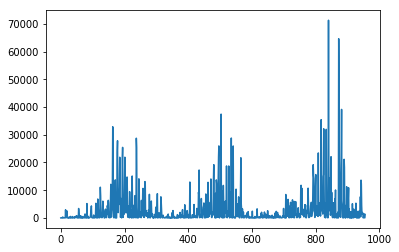

In [122]:
df.sort_values(['year','month', 'week','julian_day'])['count'].plot()

In [123]:
len(df)

956

In [124]:
retuned_values[0]

{'alert_date': '2015-01-01', 'count': 8, 'julian_day': 1, 'year': 2015}